# Stratified KFold for the OM dataset

This code helps split a dataset in COCO format for Instance Segmentation given labels distributions across the dataset splits. The algorithm is used for preserving the samples percentages for each class in order to provide a smoother generalization and adress class imbalance. 

## Setup

In [17]:
import json
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
import os
import sys

sys.path.append('/workspace/raid/OM_DeepLearning/XAMI-dataset/')

import xami_utils
from xami_utils import utils

## Load the dataset

This section assumes that the images and the annotation file are in a single directory.

In [5]:
dataset_path = './xmm_om_artefacts_512-38-COCO/train/'
json_file_path = dataset_path+'_annotations.coco.json'

with open(json_file_path) as f:
    data_in = json.load(f)
data_in['categories']

[{'id': 0, 'name': 'central-ring', 'supercategory': 'artefact'},
 {'id': 1, 'name': 'other', 'supercategory': 'artefacts'},
 {'id': 2, 'name': 'read-out-streak', 'supercategory': 'artefacts'},
 {'id': 3, 'name': 'smoke-ring', 'supercategory': 'artefacts'},
 {'id': 4, 'name': 'star-loop', 'supercategory': 'artefacts'}]

## Stratified KFold

In [6]:
images, labels = [], []

for k in range(len(data_in['images'])):
    img_id = data_in['images'][k]['id']
    annotations = [data_in['annotations'][j] for j in range(len(data_in['annotations'])) if data_in['annotations'][j]['image_id'] == img_id]
    categories = set(str(annot['category_id']) for annot in annotations)
    images.append([img_id])
    labels.append(''.join(list(categories)))
        
images, labels = np.array(images), np.array(labels)

In [7]:
np.unique(labels).shape

(26,)

The resulting arrays' size equals to the number of annotations because image ids are repeated for each label associated with them.

In [8]:
images.shape, labels.shape

((1055, 1), (1055,))

Run the Stratified KFold split and generate train and valid datasets given the number of splits. 

The split percentage is calculated depending on the `n_splits` parameter:

> train_percentage = int(100 * 1/n_splits)
>
> valid_percentage = 100 - train_percentage

In [9]:
skf_image_ids, skf_labels, kf_image_ids, kf_labels = {}, {}, {}, {}

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# skf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

for i, (train_index, valid_index) in enumerate(skf.split(images, labels)):
    skf_image_ids[i] = {'train': images[train_index], 'valid': images[valid_index]}
    skf_labels[i] = {'train': labels[train_index], 'valid': labels[valid_index]}

for i, (train_index, valid_index) in enumerate(kf.split(images, labels)):
    kf_image_ids[i] = {'train': images[train_index], 'valid': images[valid_index]}
    kf_labels[i] = {'train': labels[train_index], 'valid': labels[valid_index]}

The least populated class in y has only 1 members, which is less than n_splits=4.


In [10]:
len(train_index), len(valid_index)

(792, 263)

In [11]:
len(skf_image_ids), 'splits'

(4, 'splits')

**Ensure that there are no image ids present in both splits.**

In [12]:
for i in range(n_splits):
    print("intersection", len(np.intersect1d(skf_image_ids[i]['train'], skf_image_ids[i]['valid'])))

intersection 0
intersection 0
intersection 0
intersection 0


**Ensure that the labels distribution is roughly the same between splits.**

In [18]:
labels_percentages_skf = utils.percentages(n_splits, skf_image_ids, skf_labels)
labels_percentages_kf = utils.percentages(n_splits, kf_image_ids, kf_labels)
labels_percentages_skf

{0: {'train': {'0': 0.25510204081632654,
   '1': 0.00816326530612245,
   '2': 0.24846938775510205,
   '3': 0.21989795918367347,
   '4': 0.2683673469387755,
   '5': 0.0},
  'valid': {'0': 0.2553191489361702,
   '1': 0.007598784194528876,
   '2': 0.24924012158054712,
   '3': 0.22036474164133737,
   '4': 0.2674772036474164,
   '5': 0.0}},
 1: {'train': {'0': 0.25558943089430897,
   '1': 0.008130081300813009,
   '2': 0.24898373983739838,
   '3': 0.21951219512195122,
   '4': 0.26778455284552843,
   '5': 0.0},
  'valid': {'0': 0.25384615384615383,
   '1': 0.007692307692307693,
   '2': 0.24769230769230768,
   '3': 0.22153846153846155,
   '4': 0.2692307692307692,
   '5': 0.0}},
 2: {'train': {'0': 0.25472179683512,
   '1': 0.007656967840735069,
   '2': 0.24859622256253192,
   '3': 0.22052067381316998,
   '4': 0.2685043389484431,
   '5': 0.0},
  'valid': {'0': 0.2564491654021244,
   '1': 0.009104704097116844,
   '2': 0.2488619119878604,
   '3': 0.21851289833080426,
   '4': 0.26707132018209406,


In [19]:
labels_percentages_kf

{0: {'train': {'0': 0.25673614641586173,
   '1': 0.007625826131164209,
   '2': 0.2470767666497204,
   '3': 0.21962379257752923,
   '4': 0.26893746822572445,
   '5': 0.0},
  'valid': {'0': 0.250384024577573,
   '1': 0.009216589861751152,
   '2': 0.2534562211981567,
   '3': 0.22119815668202766,
   '4': 0.26574500768049153,
   '5': 0.0}},
 1: {'train': {'0': 0.2530737704918033,
   '1': 0.007172131147540984,
   '2': 0.2489754098360656,
   '3': 0.2192622950819672,
   '4': 0.27151639344262296,
   '5': 0.0},
  'valid': {'0': 0.26126126126126126,
   '1': 0.010510510510510511,
   '2': 0.24774774774774774,
   '3': 0.2222222222222222,
   '4': 0.25825825825825827,
   '5': 0.0}},
 2: {'train': {'0': 0.2570404505888377,
   '1': 0.00819252432155658,
   '2': 0.2488479262672811,
   '3': 0.22171018945212492,
   '4': 0.2642089093701997,
   '5': 0.0},
  'valid': {'0': 0.24962406015037594,
   '1': 0.007518796992481203,
   '2': 0.24812030075187969,
   '3': 0.21503759398496242,
   '4': 0.2796992481203007,
  

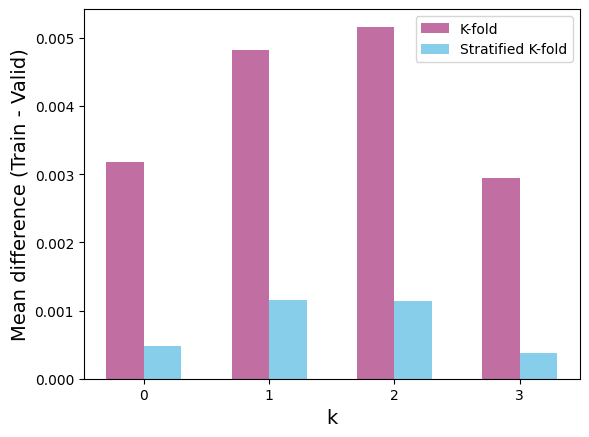

In [21]:
import matplotlib.pyplot as plt

results = labels_percentages_kf
results_skf = labels_percentages_skf

colors = ['#89D8CD', '#9F156480', '#FFBCF880', '#FFBCF880', '#FFBCF880']

label_diffs = {i: {label: abs(results[i]['train'][label] - results[i]['valid'][label])
                   for label in results[i]['train']} for i in results}
label_diffs_skf = {i: {label: abs(results_skf[i]['train'][label] - results_skf[i]['valid'][label])
                   for label in results_skf[i]['train']} for i in results_skf}

diff_array = np.array([[label_diffs[iteration][label] for label in sorted(label_diffs[iteration])]
                       for iteration in sorted(label_diffs)])
mean_array = np.array([np.mean(diff_array[i, :]) for i in range(diff_array.shape[0])])

diff_array_skf = np.array([[label_diffs_skf[iteration][label] for label in sorted(label_diffs_skf[iteration])]
                       for iteration in sorted(label_diffs_skf)])
mean_array_skf = np.array([np.mean(diff_array_skf[i, :]) for i in range(diff_array_skf.shape[0])])

indices = np.arange(len(mean_array))

# bar width
width = 0.3

fig, ax = plt.subplots()
bars1 = ax.bar(indices - width/2, mean_array, width, label='K-fold', color='#C16FA3')
bars2 = ax.bar(indices + width/2, mean_array_skf, width, label='Stratified K-fold', color='skyblue')

plt.xlabel('k', fontsize=14)
plt.ylabel('Mean difference (Train - Valid)', fontsize=14)
ax.set_xticks(indices)
ax.set_xticklabels([str(i) for i in indices])
ax.legend()
plt.savefig('../plots/kf_skf_errors.png', dpi=400)
plt.show()

# Generate CSV files with new splits

For optimization, we organise the dataset into CSV files which can be later used for generating split directories, given the original dataset direcory. There will be *k* such CSV files. 

In principle, one can use a single split, but for a better understanding of the model's performance, running model for multiple k folds and averaging results is a better approach. 

In [22]:
import csv

def write_csv(skf_image_ids):
    for mskf in skf_image_ids.keys():
        with open(f'mskf_{mskf}.csv', 'w', newline='') as csvfile:
            fieldnames = ['IMADE_ID', 'IMAGE_PATH', 'SPLIT']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for split in skf_image_ids[mskf].keys():
                for image in skf_image_ids[mskf][split]:
                    image_id = image[0]
                    filename = data_in['images'][image_id]['file_name']
                    writer.writerow({
                        'IMADE_ID': image_id,
                        'IMAGE_PATH': os.path.join(dataset_path, filename),
                        'SPLIT': split
                    })

write_csv(skf_image_ids)

In [23]:
import pandas as pd

# Generate split directories (COCO Instance Segmentation format)
csv_files = ['mskf_0.csv', 'mskf_1.csv', 'mskf_2.csv', 'mskf_3.csv'] 

for idx, csv_file in enumerate(csv_files):
    mskf = pd.read_csv(csv_file)
    utils.create_directories_and_copy_files('.', data_in, mskf, idx)

Dataset split for mskf_0 was successful.
Dataset split for mskf_1 was successful.
Dataset split for mskf_2 was successful.
Dataset split for mskf_3 was successful.


# Convert COCO annotations to YOLO segmentation (Optional)

In [24]:
# TODO: convert to YOLO segm, not bbox only
from xami_utils import coco_to_yolo_converter
import yaml 

convert = True

if convert:

    classes = [str(cat['name']) for cat in data_in['categories'] if 'artefacts' not in cat['name']]
    absolute_path = '/workspace/raid/OM_DeepLearning/XAMI-dataset/notebooks/xmm_om_artefacts_512-38-COCO/'
    for iter in range(n_splits):
        for mode in ['train', 'valid']:
            
            input_path = f"./mskf_{iter}/{mode}"

            # adding '/' at the end will give an error for the parent directory
            output_path = f"./mskf_YOLO_{iter}/{mode}"
            input_json_train = f"_annotations.coco.json"
            converter = coco_to_yolo_converter.COCOToYOLOConverter(input_path, output_path, input_json_train, plot_yolo_masks=False)
            converter.convert()
            
            # generate data.yaml
            yaml_path = os.path.dirname(output_path)+f'/data.yaml'

            if mode =='valid': # train and valid folder successfully created
                yolo_data = {
                    'names': classes,
                    'nc': len(classes),
                    'train': f'{os.path.join(absolute_path, os.path.dirname(output_path)).replace(".", "").replace("//", "/")}/train/images',
                    'val': f'{os.path.join(absolute_path, os.path.dirname(output_path)).replace(".", "").replace("//", "/")}/valid/images'
                }
                
                # Write the data to a YAML file
                with open(yaml_path, 'w') as file:
                    yaml.dump(yolo_data, file, default_flow_style=False)
                
                print(f"YAML file {yaml_path} created and saved.")

Processed 791 files.
Processed 264 files.
YAML file ./mskf_YOLO_0/data.yaml created and saved.
Processed 791 files.
Processed 264 files.
YAML file ./mskf_YOLO_1/data.yaml created and saved.
Processed 791 files.
Processed 264 files.
YAML file ./mskf_YOLO_2/data.yaml created and saved.
Processed 792 files.
Processed 263 files.
YAML file ./mskf_YOLO_3/data.yaml created and saved.


### Check generated images and annotations

In [ ]:
# Some sanity check

In [ ]:
category_mapping = { 0:('central-ring', (1,252,214)), 
            1:('other', (255,128,1)),
            2:('read-out-streak', (20, 77, 158)), 
            3:('smoke-ring', (159,21,100)),
            4:('star-loop', (255, 188, 248))}

dataset_dir = './mskf_YOLO_0/train/'
for filename in os.listdir(dataset_dir+'images/'):
    print(filename)
    image_path = dataset_dir+'images/'+filename
    annotation_file = dataset_dir+'labels/'+filename.replace(".jpg", '.txt')
    annotations = utils.read_yolo_annotations(annotation_file)
    utils.plot_yolo_segmentations(image_path, annotations, category_mapping)

In [ ]:
with open('./mskf_0/train/_annotations.coco.json') as f:
    data_0 = json.load(f)
with open('./mskf_1/train/_annotations.coco.json') as f:
    data_1 = json.load(f)
with open('./mskf_2/train/_annotations.coco.json') as f:
    data_2 = json.load(f)
with open('./mskf_3/train/_annotations.coco.json') as f:
    data_3 = json.load(f)

In [ ]:
[i for i in range(len(skf_image_ids[0]['train'])) if skf_image_ids[0]['train'][i] - [image['id'] for image in data_0['images']][i] != 0]

In [ ]:
[i for i in range(len(skf_image_ids[1]['train'])) if skf_image_ids[1]['train'][i] - [image['id'] for image in data_1['images']][i] != 0]

In [ ]:
[i for i in range(len(skf_image_ids[2]['train'])) if skf_image_ids[2]['train'][i] - [image['id'] for image in data_2['images']][i] != 0]

In [ ]:
[i for i in range(len(skf_image_ids[3]['train'])) if skf_image_ids[3]['train'][i] - [image['id'] for image in data_3['images']][i] != 0]